<div style="display: flex; align-items: center;">
    <div style="display: flex; flex-direction: column; align-items: center;">
        <h1 style="text-align: right;">Centro de Investigación en Matemáticas, A.C.</h1>
        <h2 style="text-align: right;">Reconocimiento de Patrones</h2>
        <h3 style="text-align: right;">Tarea 4</h3>
    </div>
    <img src="Figures\logoCIMAT11.png" alt="CIMAT Logo" width="200" style="float: left;">
</div>


---

## Ejercicio 1

Busca árboles de decisión adecuados para los datos de pinguinos (considerando las 3 familias, sin considerar la isla). Discute los resultados. Compara los resultados con K-NN.

**Árboles de decisión**

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn import datasets, manifold
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
import seaborn as sns
from collections import defaultdict
from palmerpenguins import load_penguins

Cargamos los datos de pingüinos y eliminamos las filas con valores nulos.

In [2]:
# Load the penguins dataset into a pandas DataFrame
penguins = load_penguins()

# Remove any rows with missing values from the 'penguins' DataFrame
penguins = penguins.dropna(axis=0, how="any")

# Create a new DataFrame that excludes the 'species', 'island', and 'sex' columns
data = penguins.drop(columns=['species', 'island','sex'])

# Map the 'sex' column values to numerical labels (0 for male, 1 for female)
data['female'] = penguins['sex'].map({'male': 0, 'female': 1})

# Extract the target variable from the original DataFrame
target = penguins['species']

# Define a list of class labels for the classification task
classes = ['Adelie', 'Chinstrap', 'Gentoo']

Separamos el conjunto de datos en conjunto de entrenamiento y prueba

In [3]:
# Split the dataset
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=1601/4601, random_state=42
)

**Ajustar un arbol.**

Ajustamos el árbol de decisión sin restricciones para iniciar:

In [4]:
# Train decision tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(train_data, train_target)

DecisionTreeClassifier(random_state=42)

A continuación, mostramos el árbol de decisión ajustado sin restricciones.



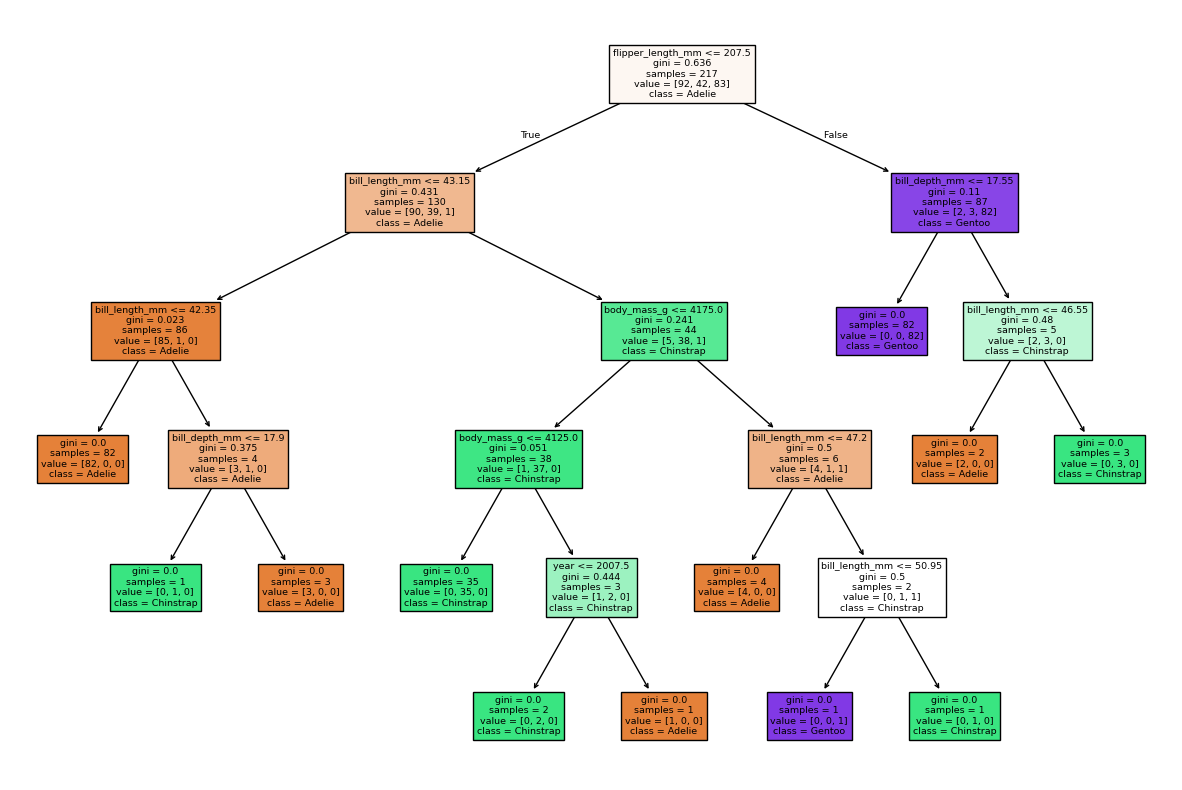

In [5]:
# Plot tree
plt.figure(figsize=(15, 10))
plot_tree(clf, feature_names=data.columns, class_names=classes, filled=True)
plt.show()

Predecimos las clasificaciones para el conjunto de prueba y obtenemos el reporte de clasificación:

In [6]:
# Predict classes for decision tree
class_predictions = clf.predict(test_data)
# Confusion Matrix
conf_matrix = confusion_matrix(test_target, class_predictions)
# Classification Report
accuracy = balanced_accuracy_score(test_target, class_predictions)
print("Classification Report:")
print(classification_report(test_target, class_predictions))
print(f"Model Accuracy: {accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

      Adelie       0.96      0.96      0.96        54
   Chinstrap       0.92      0.88      0.90        26
      Gentoo       0.95      0.97      0.96        36

    accuracy                           0.95       116
   macro avg       0.94      0.94      0.94       116
weighted avg       0.95      0.95      0.95       116

Model Accuracy: 0.9399


Ahora, mostramos la matriz de confusión para el árbol sin restricciones

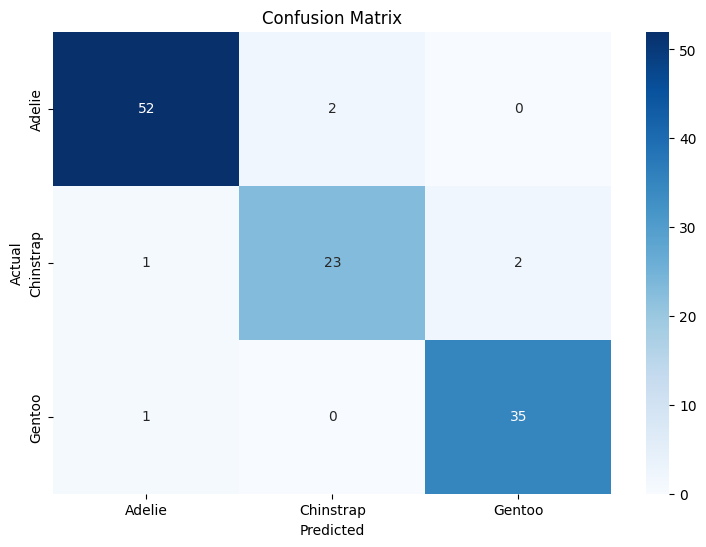

In [7]:
# Plot Confusion Matrix
plt.figure(figsize=(9, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**Adición del costo por tamaño del árbol**

Ahora, consideramos la función de costo aumentada, si bien no por la profundidad del árbol, por el número de ramas que tiene. Para los diferentes valores de $\alpha$, obtenemos el score del ajuste de los árboles en el conjunto de pruebas, de forma que elijamos el árbol con mejor resultado.


In [8]:
# Find optimal ccp_alpha for pruning by obtaining cost complexity path
path = clf.cost_complexity_pruning_path(train_data, train_target)
# Extract ccp_alphas excluding max alpha which prunes everything
ccp_alphas = path.ccp_alphas[:-1]

# Train Decision Trees with different ccp_alpha values
# This will evaluate the effect of pruning on model performance
clfs = [DecisionTreeClassifier(ccp_alpha=alpha, random_state=42).fit(train_data, train_target) for alpha in ccp_alphas]

# Compute balanced accuracy scores for both training and test sets
train_scores = [balanced_accuracy_score(train_target, clf.predict(train_data)) for clf in clfs]
test_scores = [balanced_accuracy_score(test_target, clf.predict(test_data)) for clf in clfs]


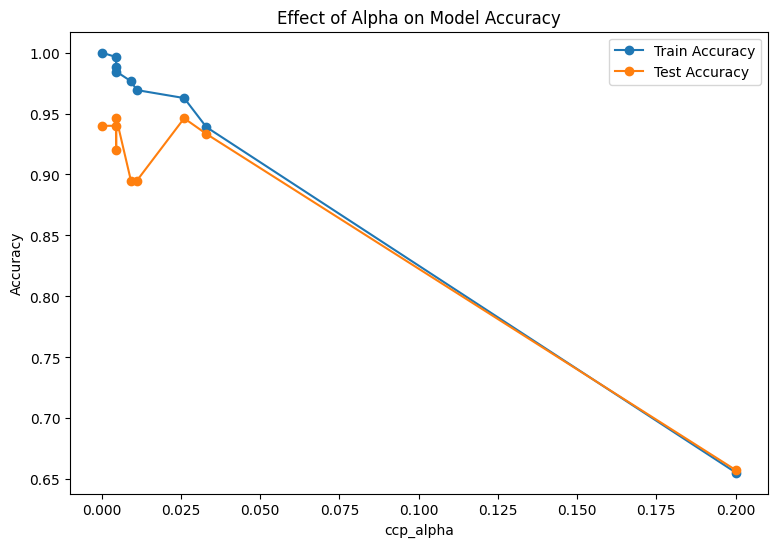

In [9]:

# Plot alpha vs accuracy
plt.figure(figsize=(9, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='Train Accuracy')
plt.plot(ccp_alphas, test_scores, marker='o', label='Test Accuracy')
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Effect of Alpha on Model Accuracy")
plt.show()


Podemos observar que el máximo score para los valores de $\alpha$ se alcanza aproximadamente en 0.004, un valor relativamente pequeño, lo que nos indica que el árbol original no tenía un sobreajuste tan grande. El valor exacto lo encontramos a continuación:

In [10]:
# Select best alpha (where test accuracy is maximized)
best_alpha = ccp_alphas[np.argmax(test_scores)]
print(f"Optimal ccp_alpha: {best_alpha:.6f}")


Optimal ccp_alpha: 0.004608


Podamos el árbol para el $\alpha$ óptimo:

In [11]:
# Train pruned decision tree
clf_pruned = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)
clf_pruned.fit(train_data, train_target)


DecisionTreeClassifier(ccp_alpha=np.float64(0.004608294930875576),
                       random_state=42)

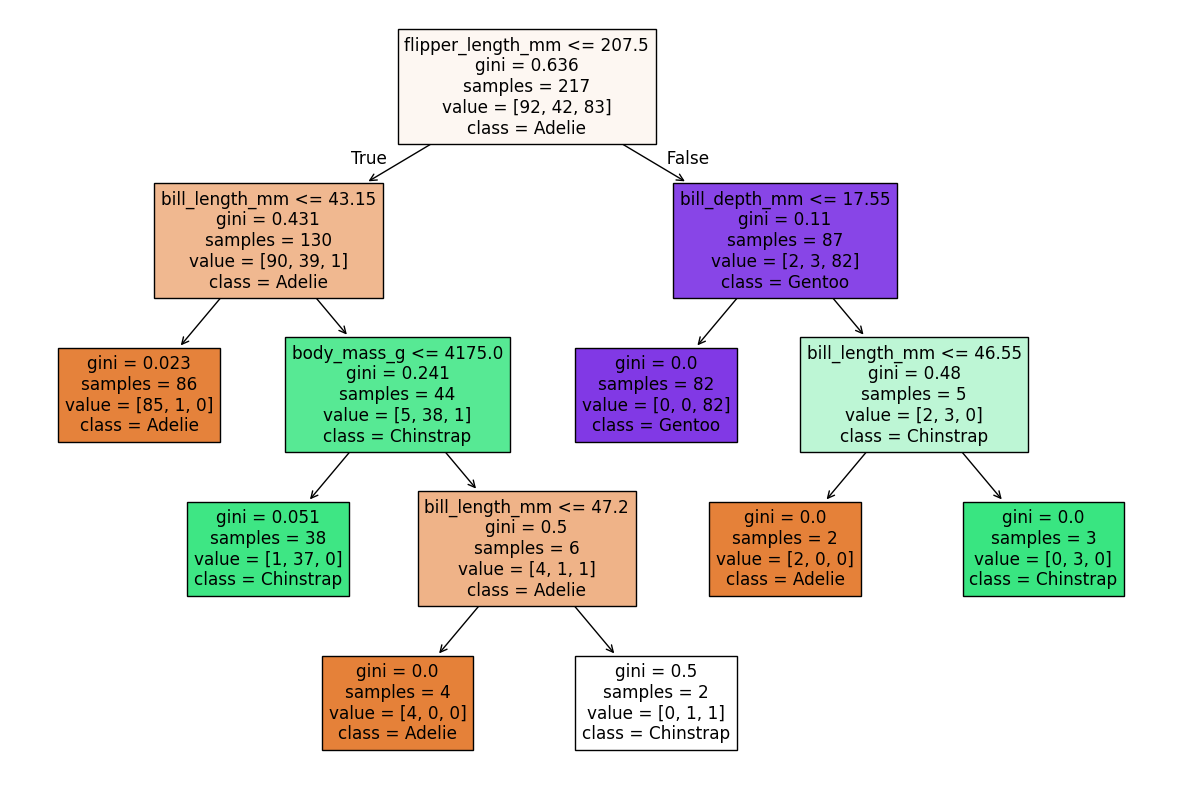

In [12]:
# Plot the pruned tree

plt.figure(figsize=(15, 10))
plot_tree(clf_pruned, feature_names=data.columns, class_names=classes, filled=True)
plt.show()


In [13]:
# Predict classes for pruned tree
class_predictions_pruned = clf_pruned.predict(test_data)

# Confusion Matrix for pruned tree
conf_matrix_pruned = confusion_matrix(test_target, class_predictions_pruned)

# Model Accuracy for pruned tree
accuracy_pruned = balanced_accuracy_score(test_target, class_predictions_pruned)

# Classification Report for k-NN
print("Classification Report (Pruned Tree):")
print(classification_report(test_target, class_predictions_pruned))
print(f"Model Accuracy (Pruned Tree): {accuracy_pruned:.4f}")


Classification Report (Pruned Tree):
              precision    recall  f1-score   support

      Adelie       0.93      0.98      0.95        54
   Chinstrap       0.96      0.88      0.92        26
      Gentoo       1.00      0.97      0.99        36

    accuracy                           0.96       116
   macro avg       0.96      0.95      0.95       116
weighted avg       0.96      0.96      0.96       116

Model Accuracy (Pruned Tree): 0.9461


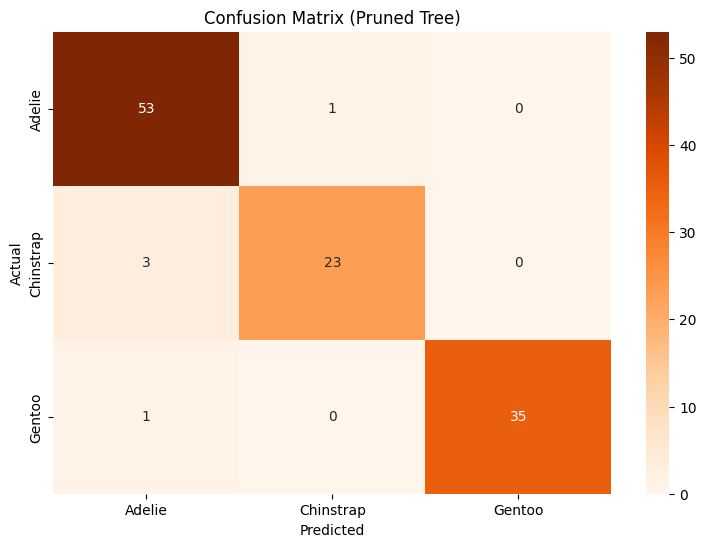

In [14]:
# Plot Confusion Matrix for pruned tree
plt.figure(figsize=(9, 6))
sns.heatmap(conf_matrix_pruned, annot=True, fmt="d", cmap="Oranges", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Pruned Tree)")
plt.show()

**K-NN**

Ahora, consideraremos la clasificación por $k$-Nearest Neighbors. Para eso, primero debemos elegir el valor de $k$ que mejor ajuste a los datos:

In [15]:
# Set the maximum value for k in KNN classifier
max_k = 40

# Define a range of values from 1 to max_k (inclusive)
k_range = range(1, max_k + 1)

# Initialize an empty list to store scores
scores = []

# Iterate over each value of k in the defined range
for k in k_range:
    # Create a KNN classifier with the current value of k
    knn_clf = KNeighborsClassifier(n_neighbors=k)

    # Train the model on the training data
    knn_clf.fit(train_data, train_target)

    # Use the trained model to make predictions on test data
    predictions = knn_clf.predict(test_data)

    # Calculate the performance metric (in this case, balanced accuracy score)
    score = balanced_accuracy_score(test_target, predictions)

    # Store the calculated score in the scores list
    scores.append(score)

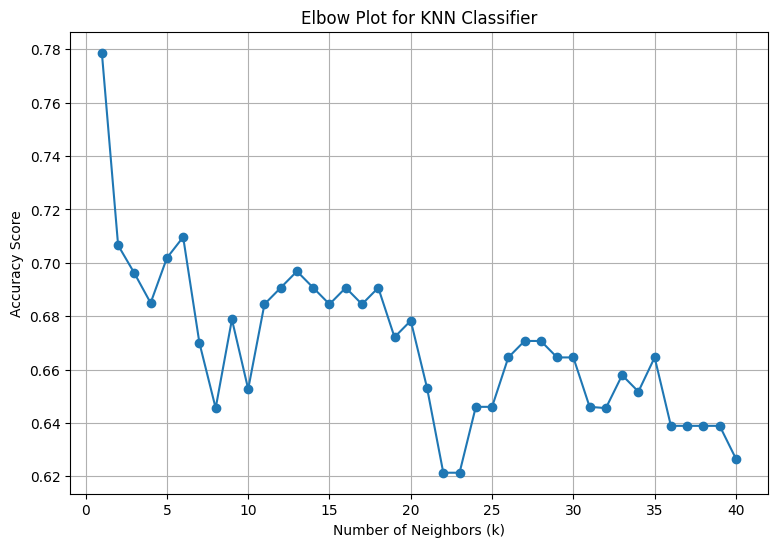

In [16]:
plt.figure(figsize=(9, 6))
plt.plot(k_range, scores, marker='o')
plt.title('Elbow Plot for KNN Classifier')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

Vemos que, en este caso, es mejor tomar un solo vecino, por lo que así lo hacemos.

In [17]:
# Fit optimal K-NN model
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_data, train_target)


KNeighborsClassifier(n_neighbors=1)

In [18]:
# Predict classes for K-NN
class_predictions_neigh = neigh.predict(test_data)

# Confusion Matrix for k-NN
conf_matrix_neigh = confusion_matrix(test_target, class_predictions_neigh)

# Model Accuracy for k-NN
accuracy_neigh = balanced_accuracy_score(test_target, class_predictions_neigh)

# Classification Report for k-NN
print("Classification Report (k-Nearest Neighbors):")
print(classification_report(test_target, class_predictions_neigh))
print(f"Model Accuracy (k-Nearest Neighbors): {accuracy_neigh:.4f}")

Classification Report (k-Nearest Neighbors):
              precision    recall  f1-score   support

      Adelie       0.85      0.81      0.83        54
   Chinstrap       0.60      0.58      0.59        26
      Gentoo       0.87      0.94      0.91        36

    accuracy                           0.80       116
   macro avg       0.77      0.78      0.78       116
weighted avg       0.80      0.80      0.80       116

Model Accuracy (k-Nearest Neighbors): 0.7787


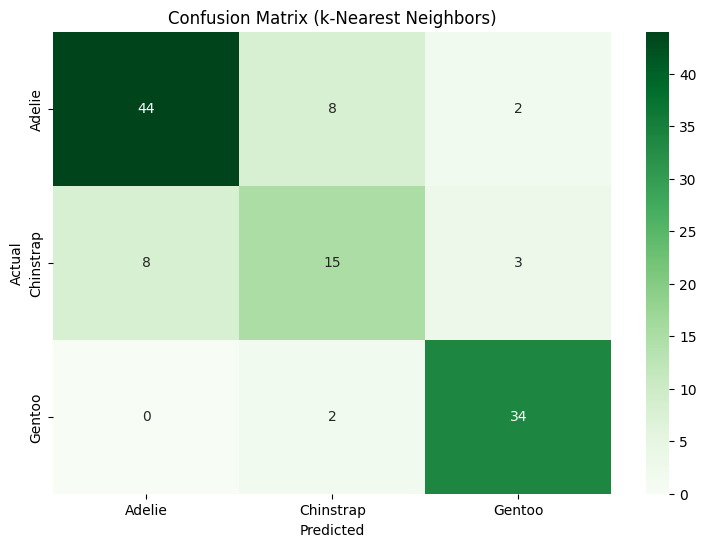

In [19]:
# Plot Confusion Matrix for k-NN
plt.figure(figsize=(9, 6))
sns.heatmap(conf_matrix_neigh, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (k-Nearest Neighbors)")
plt.show()


Observamos que este método es peor que árboles de decisión para estos datos.

## Ejercicio 2

El clasificador ingenuo Bayesiano consiste en suponer que $X\mid Y = y$ tiene componentes independientes, es decir: $\mathbb{P}(X = x\mid Y = y) = ∏_i \mathbb{P}(X_i = x_i \mid Y = y)$. Tiene la ventajas que ya no se debe estimar una distribución
multivariada, sino (muchas) univariadas.

En el caso en que tenemos varias categorias, recordemos que el costo esperado está dado por:

$$
C(x,y)=\sum_{y} L(y,\hat{Y}(x)) \mathbb{P}(X=x\mid Y=y) \mathbb{P}(Y=y)
$$

Para el clasificador ingenuo bayesiano, asumiremos:
1. **Independencia**: Las variables $X_1, X_2, \dots, X_d $ son independientes dado $Y=y$, de forma que:
   
   $$
   C(x,y)=\sum_{y} L(y,\hat{Y}(x)) \prod_{i=1}^{d} P(X_i = x_i \mid Y = y) \mathbb{P}(Y=y).
   $$
   
2. **Normalidad**: En este caso, supondremos que $X_i \mid Y=y$ son v.a.s distribuidas normalmente:
   
   $$
   X_i \mid Y = y \sim \mathcal{N}(\mu_{i,y}, \sigma_{i,y}^2).
   $$
   
   Esto es:
   
   $$
   P(X_i = x_i \mid Y = y) = \frac{1}{\sqrt{2\pi \sigma_{i,y}^2}} \exp \left( -\frac{(x_i - \mu_{i,y})^2}{2 \sigma_{i,y}^2} \right).
   $$

Entonces, para cada $x$ debemos elegir $\hat{Y}(x)$ tal que minimice el costo esperado.

Para esta implementación, estimaremos $P(Y=y)$ por la frecuencia entre el total para la categoría $y$. Estimamos $\mu_{i,y}$ y $\sigma_{i,y}$ por sus EMV.

In [20]:
class NaiveBayesGaussian:
    """
    This class implements a Naive Bayes classifier assuming Gaussian distributions with Laplace smoothing.

    Attributes:
        classes (list): A list of unique class labels in the training data.
        class_map (dict): A dictionary mapping non-numeric class labels to integers.
        priors (dict): A dictionary storing prior probabilities for each class.
        means (dict): A dictionary storing the mean values for each feature per class.
        variances (dict): A dictionary storing the variance values for each feature per class.
        alpha (float): The Laplace smoothing parameter.
    """
    def __init__(self):
        # Initialize attributes to store model parameters
        self.classes = None
        self.class_map = {}
        self.priors = {}
        self.means = {}
        self.variances = {}
        # Set the Laplace smoothing parameter to 1.0 by default
        self.alpha = 1.0
        # Initialize a list to store losses for each class
        self.loss = []

    def fit(self, X_train, y_train):
        """
        Fit the Naïve Bayes classifier assuming Gaussian distributions with Laplace smoothing.

        Args:
            X_train (array-like): The training features.
            y_train (array-like): The training labels.

        Returns:
            None
        """
        # Map non-numeric class labels to integers
        self.classes = np.unique(y_train)
        # Create a dictionary mapping class labels to indices
        self.class_map = {label: idx for idx, label in enumerate(self.classes)}
        # Encode the training labels using the class map
        y_train_encoded = np.array([self.class_map[label] for label in y_train])
        n_samples, n_features = X_train.shape

        # Iterate over each class to calculate model parameters
        for c in self.classes:
            # Get the features corresponding to the current class
            X_c = X_train[y_train_encoded == self.class_map[c]]

            # Add Laplace smoothing to prior probabilities
            count = len(X_c)
            # Calculate the prior probability using Laplace smoothing
            self.priors[c] = (count + self.alpha) / (n_samples + self.alpha * len(self.classes))

            if n_features > 0:
                # Calculate the mean for each feature per class
                self.means[c] = np.mean(X_c, axis=0)
                # Calculate the variance for each feature per class
                self.variances[c] = np.var(X_c, axis=0, ddof=1) + 1e-8
            else:
                # If there are no features, set mean and variance to default values
                self.means[c] = 0.0
                self.variances[c] = 1e-8

    def _classify(self, x):
        """
        Classify a single sample using the Naive Bayes classifier with Laplace smoothing.

        Args:
            x (array-like): The input sample to classify.

        Returns:
            str: The predicted class label.
        """
        # Initialize a dictionary to store posteriors for each class
        posteriors = {}
        # Iterate over each class to calculate posteriors
        for c in self.classes:
            # Calculate the prior probability for the current class
            prior = np.log(self.priors[c])
            # Calculate the likelihood using the Gaussian distribution
            likelihood = np.sum(norm.logpdf(x.astype(np.float64), self.means[c].astype(np.float64), np.sqrt(self.variances[c]).astype(np.float64)))
            # Store the posterior probability for the current class
            posteriors[c] = prior + likelihood
        # Calculate the expected loss for each class multiplying by the loss matrix
        all_expected_losses = self.loss @ np.exp(np.array(list(posteriors.values())))
        expected_loss = {}
        i = 0
        for c in self.classes:
            expected_loss[c] = all_expected_losses[i]
            i += 1
        # Return the class with the lowest expected loss
        return min(expected_loss, key=expected_loss.get)

    def predict(self, X_test, loss_matrix):
        """
        Predict the class labels for input samples.

        Args:
            X_test (array-like): The input features to classify.
            loss_matrix (array-like): A matrix storing losses for each class.

        Returns:
            array-like: An array of predicted class labels.
        """
        # Store the loss matrix in the model
        self.loss = loss_matrix
        predictions = [self._classify(x) for x in X_test]
        # Map the numeric class predictions back to original class labels
        return np.array([self.classes[self.class_map[class_pred]] for class_pred in predictions])

Ahora, lo probaremos en los datos de los pingûinos. Debemos transformar los datos primero a arrays en vez de dataframes. Utilizaremos costos iguales para errar la predicción, pero es posible cambiarlos al modificar la matriz loss.

In [21]:
# Load training and testing data values into numpy arrays
X_train = train_data.values  # Assign training data feature values to X_train array
X_test = test_data.values    # Assign testing data feature values to X_test array

# Create a 3x3 matrix with ones, then subtract the identity matrix (np.eye(3)) to create a custom loss function matrix
loss = np.ones((3,3)) - np.eye(3)

# Initialize Naive Bayes Gaussian classifier
nb = NaiveBayesGaussian()    # Initialize Naive Bayes Gaussian classifier instance

# Train the model using training data features (X_train) and target labels (train_target)
nb.fit(X_train, train_target)

Predecimos en el conjunto de prueba:

In [22]:
# Predict classes for Naive Bayes
class_predictions_nb = nb.predict(X_test, loss)

# Confusion Matrix for Naive Bayes
conf_matrix_nb = confusion_matrix(test_target, class_predictions_nb)

# Model Accuracy for Naive Bayes
accuracy_nb = balanced_accuracy_score(test_target, class_predictions_nb)

# Classification Report for Naive Bayes
print("Classification Report (Naive Bayes):")
print(classification_report(test_target, class_predictions_nb))
print(f"Model Accuracy (Naive Bayes): {accuracy_nb:.4f}")

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

      Adelie       0.95      1.00      0.97        54
   Chinstrap       1.00      0.88      0.94        26
      Gentoo       1.00      1.00      1.00        36

    accuracy                           0.97       116
   macro avg       0.98      0.96      0.97       116
weighted avg       0.98      0.97      0.97       116

Model Accuracy (Naive Bayes): 0.9615


Vemos que este método ha resultado más preciso que árboles de decisión y que k-Nearest Neighbors. A continuación la matriz de confusión.

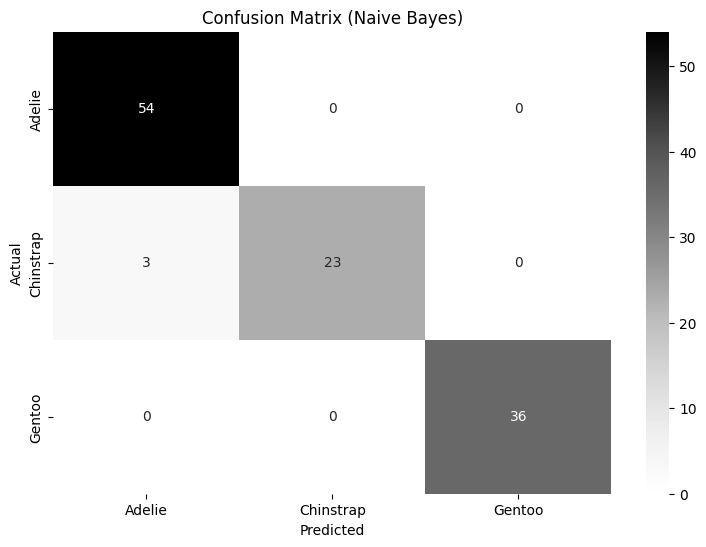

In [23]:
# Plot Confusion Matrix for Naive Bayes
plt.figure(figsize=(9, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Greys", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Naive Bayes)")
plt.show()


Dada la precisión del modelo, es posible que en efecto las variables sean independientes y distribuidas normalmente. Incluso, sería interesante verificar si con una penalización diferente por elegir incorrectamente podemos mejorar el resultado.

## Ejercicio 3

Supongamos que se usa la codificación $y \in {-1, 1}$. Verifica que el modelo de RL es de la forma:
$$
\mathbb{P}(Y=y\mid X=x) = \frac{1}{1 + \exp(-y(\alpha + \beta^{\top}x))}
$$

En regresión logística, queremos estimar:
$$
\log\left(\frac{\mathbb{P}(Y=1\mid X=x)}{\mathbb{P}(Y=-1\mid X=x)}\right) = \alpha + \beta^{\top}x,\\
\log\left(\frac{p}{1-p}\right) = \alpha + \beta^{\top}x,\\
p = \frac{1}{1 + \exp(-\alpha - \beta^{\top}x)},\\
1-p = 1 - \frac{1}{1 + \exp(-\alpha - \beta^{\top}x)},\\
1-p = \frac{\exp(-\alpha - \beta^{\top}x)}{1 + \exp(-\alpha - \beta^{\top}x)},\\
1-p = \frac{1}{1 + \exp(\alpha + \beta^{\top}x)}.
$$
Así tenemos el resultado deseado:
$$
\mathbb{P}(Y=y\mid X=x) = \frac{1}{1 + \exp(-y(\alpha + \beta^{\top}x))}
$$

## Ejercicio 4
Verifica cómo se obtiene la expresión del gradiente de la función de logverosimilitud para RL y que aparece en las notas.

Iniciamos por la función de logverosimilitud de la RL:
$$
l(\beta) = \sum_{i} y_i\log(\pi(x_i)) + (1-y_i) \log(1-\pi(x_i))\\
l(\beta) = \sum_{i} y_i\beta^{\top}x_i - \log(1 + \exp(\beta^{\top} x_i))
$$
Tomando el gradiente de la segunda expresión con respecto de $\beta$:
$$
\nabla l(\beta) = \sum_{i} y_i x_i - \frac{x_i \exp(\beta^{\top} x_i)}{1 + \exp(\beta^{\top} x_i)}\\
\nabla l(\beta) = \sum_{i} x_i\left(y_i - \frac{\exp(\beta^{\top} x_i)}{1 + \exp(\beta^{\top} x_i)}\right)\\
\nabla l(\beta) = \sum_{i} x_i\left(y_i - \frac{1}{1 + \exp(-\beta^{\top} x_i)}\right)\\
\nabla l(\beta) = \sum_{i} x_i\left(y_i - \pi(x_i)\right)
$$

## Ejercicio 5

Considera las siguientes muestras de dos distribuciones normales con
misma matriz de covarianza pero promedio diferente

In [24]:
df1 = pd.DataFrame({'x':np.random.normal(0, 1, 30),
                    'y': np.random.normal(0, 1, 30)})

df2 = pd.DataFrame({'x':np.random.normal(4, 1, 30),
                    'y': np.random.normal(4, 1, 30)})

# Create a list of DataFrame objects to be concatenated
frames = [df1, df2]

# Concatenate the DataFrame objects into a single DataFrame
X = pd.concat(frames)

y = np.zeros(60)
y[:30] = 1

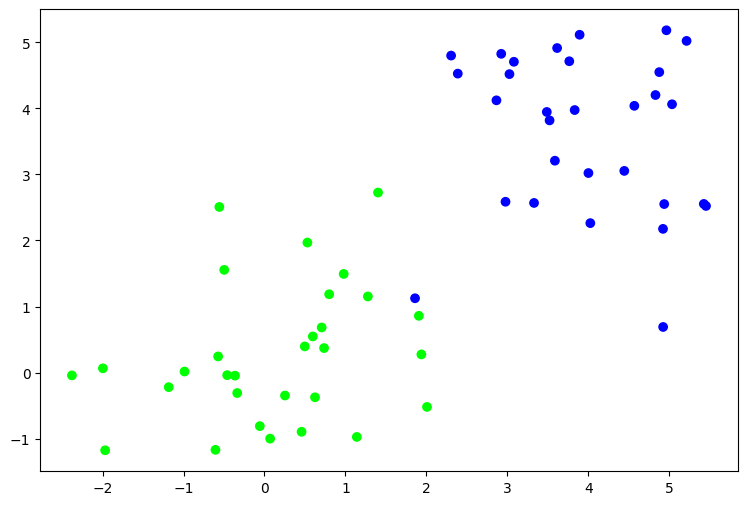

In [25]:
plt.figure(figsize=(9, 6))
plt.scatter(X['x'],X['y'], c = y, cmap = 'brg')

Añadimos una observación atípica. ¿Cuál método es más robusto a este dato atípico: LDA o regresión logística? ¿Por qué?

Primero, veamos que los dos métodos separan perfectamente las categorías.

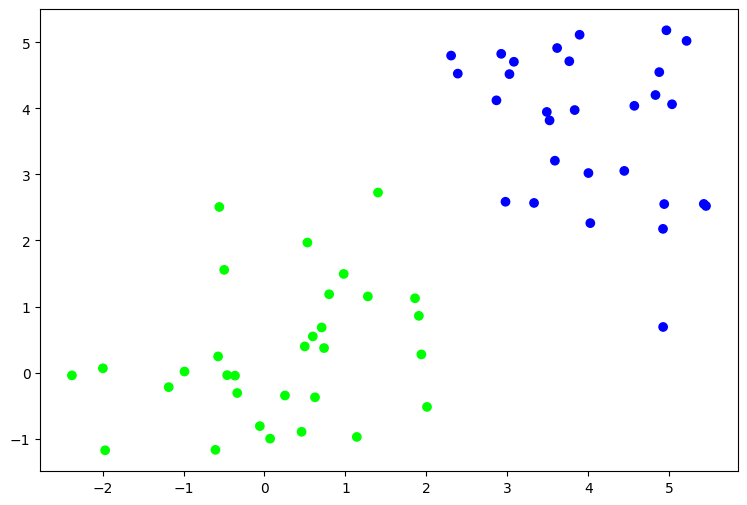

In [26]:
RL = LogisticRegression()
RL_model = RL.fit(X,y)

y_pred_RL = RL_model.predict(X)

plt.figure(figsize=(9, 6))
plt.scatter(X['x'],X['y'], c = y_pred_RL, cmap = 'brg')

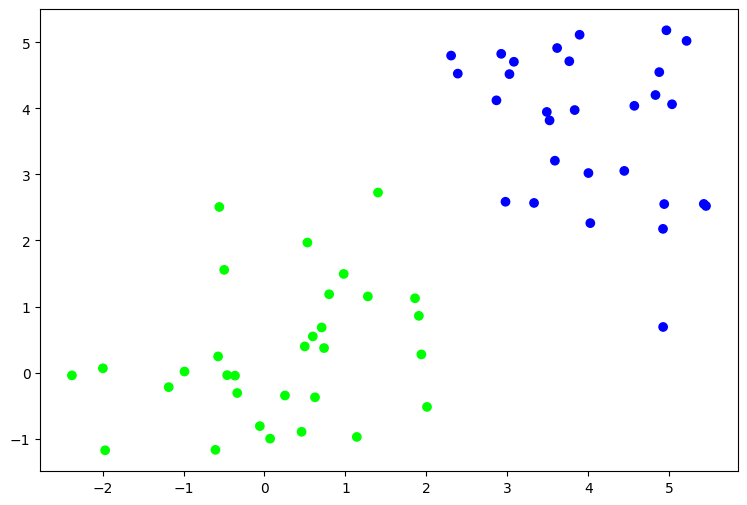

In [27]:
lda = LinearDiscriminantAnalysis(solver="eigen", store_covariance=True)
LDA_model = lda.fit(X, y)

y_pred_LDA = LDA_model.predict(X)

plt.figure(figsize=(9, 6))
plt.scatter(X['x'],X['y'], c = y_pred_LDA, cmap = 'brg')

Añadimos un outlier. Si ponemos el que viene en la tarea, ambos métodos funcionan bien, por lo que debemos ponerlo más alejado. El outlier lo clasificamos con el grupo verde, pues de otra forma no va a afectar los resultados.

In [28]:
df_outlier = pd.DataFrame({'x':np.random.normal(35, 1, 1),
                    'y': np.random.normal(35, 1, 1)})

# Concatenate df_outlier to X
X = pd.concat([X, df_outlier], axis=0)

# Update y if needed (assuming the new point is a outlier and should be classified as 1)
y = np.append(y, 1)

Ahora, volvemos a aplicar regresión logística:

In [29]:
RL_model = RL.fit(X,y)
LDA_model = lda.fit(X, y)

In [30]:
y_pred_RL = RL_model.predict(X)

# Model Accuracy for pruned tree
accuracy_RL = accuracy_score(y, y_pred_RL)
print(f"Model Accuracy (Logistic Regression): {accuracy_RL:.4f}")

Model Accuracy (Logistic Regression): 0.9672


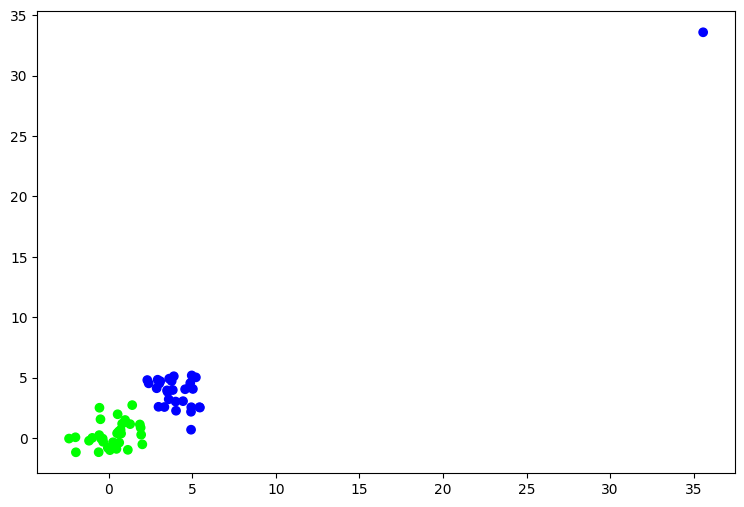

In [31]:

plt.figure(figsize=(9, 6))
plt.scatter(X['x'], X['y'], c = y_pred_RL, cmap = 'brg')

Como vemos, el modelo de regresión logística identifica las categorías correctamente, excepto el outlier.

In [32]:
y_pred_LDA = LDA_model.predict(X)

# Model Accuracy for pruned tree
accuracy_LDA = accuracy_score(y, y_pred_LDA)
print(f"Model Accuracy (Linear Discriminant Analysis): {accuracy_LDA:.4f}")

Model Accuracy (Linear Discriminant Analysis): 0.8689


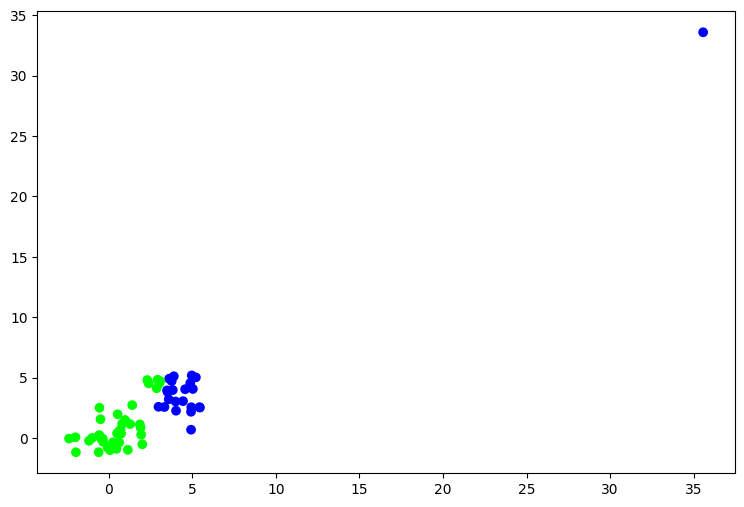

In [33]:
plt.figure(figsize=(9, 6))
plt.scatter(X['x'], X['y'], c = y_pred_LDA, cmap = 'brg')

Sin embargo, LDA no identifica las características correctamente. Esto se debe a que el outlier mueve el centroide del grupo verde lo suficiente para cambiar la predicción, mientras que se requiere un poco más para mover el corte de regresión logística. El efecto del outlier $x_o$ en el centroide es $\frac{1}{n}x_o$, mientras que (la función de costo utilizada en la práctica para RL está dividida por $n$) para RL depende del método utilizado, suponiendo descenso por gradiente es: $\frac{1}{n}x_o(y_i-\pi(x_i))$, donde $y_i-\pi(x_i)>\frac{1}{2}$ en el caso que aún se identifique incorrectamente, es decir, el efecto es menor pero aún existe.